In [1]:
import networkx as nx
import urllib.parse
import random
from networkx.algorithms import community
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np

import loader as ld
import funcs as fc

from sklearn.metrics.pairwise import cosine_similarity
from collections import deque

In [2]:
paths = ld.load_navigation_paths('data/paths_finished.tsv')
G = ld.load_wikispeedia_graph('data/links.tsv')
page_texts = ld.load_wikispeedia_data("data/plaintext_articles" )

# Find the largest strongly connected component
scc = list(nx.strongly_connected_components(G))
largest_scc = max(scc, key=len)

# Create a subgraph of DG that contains only the nodes in the largest strongly connected component
G_cc = G.subgraph(largest_scc).copy()

# Create a set of nodes in the largest strongly connected component
largest_scc_nodes = set(largest_scc)

# Function to check if a path is entirely within the largest SCC
def path_in_largest_scc(path, largest_scc):
    return all(node in largest_scc for node in path)

# Filter paths to keep only those entirely within the largest SCC
paths_cc = [path for path in paths if path_in_largest_scc(path, largest_scc_nodes)]

In [3]:
# Assuming page_texts is a dictionary with page names as keys and their contents as values
tfidf_matrix, vectorizer = ld.vectorize_texts(page_texts)
page_names = list(page_texts.keys())

# Compute the cosine similarity matrix
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Convert to a DataFrame
similarity_df = pd.DataFrame(cosine_sim_matrix, index=page_names, columns=page_names)

# Create convenient variables
node_list = list(G_cc.nodes())
pages = list(page_texts.keys())
node_index = {node: index for index, node in enumerate(node_list)}

In [5]:
# Load the results from the file
with open('floyd_warshall_results_gcc.pkl', 'rb') as file:
    dist_loaded = pickle.load(file)

In [6]:
with open('appearance_matrix.pkl', 'rb') as file:
    appearance_matrix = pickle.load(file)

In [7]:
# Load the results from the file
with open('degree_paths.pkl', 'rb') as file:
    deg_paths = pickle.load(file)
deg_path_lens = []
for path in deg_paths:
    deg_path_lens.append(len(path))

In [9]:
# Load the results from the file
with open('similarity_paths.pkl', 'rb') as file:
    sim_paths = pickle.load(file)
sim_path_lens = []
for path in sim_paths:
    sim_path_lens.append(len(path))

In [10]:
# Load the results from the file
with open('conn_paths.pkl', 'rb') as file:
    conn_paths = pickle.load(file)
conn_path_lens = []
for path in conn_paths:
    conn_path_lens.append(len(path))

In [11]:
# Load the results from the file
with open('all_pairs_shortest_paths.pkl', 'rb') as file:
    all_pairs_shortest_paths = pickle.load(file)
best_paths = []
for path in paths_cc:
    best_paths.append(all_pairs_shortest_paths[path[0]][path[-1]])
best_path_lens = []
for path in best_paths:
    best_path_lens.append(len(path))

In [16]:
user_paths = paths_cc
user_path_lens = []
for path in user_paths:
    user_path_lens.append(len(path))

In [17]:
print(len(user_paths))
print(len(deg_paths))
print(len(sim_paths))
print(len(conn_paths))
print(len(best_paths))

41936
41936
41936
41936
41936


In [18]:
print(np.mean(best_path_lens))
print(np.mean(deg_path_lens))
print(np.mean(sim_path_lens))
print(np.mean(user_path_lens))
print(np.mean(conn_path_lens))

3.8001001526135063
3.8001001526135063
3.8001001526135063
5.719739603204884
3.8001001526135063


In [19]:
# Step 1: Calculate the degree of each node
node_degrees = dict(G_cc.degree())
user_path_5 = [path for path in paths_cc if len(path) == 5]
sim_path_5 = [path for path in sim_paths if len(path) == 5]
deg_path_5 = [path for path in deg_paths if len(path) == 5]
conn_path_5 = [path for path in conn_paths if len(path) == 5]
best_path_5 = [path for path in best_paths if len(path) == 5]

In [22]:
def calculate_average_degrees(paths):
    distance_dict = {}
    for path in paths:
        reversed_path = list(reversed(path))
        for distance, node in enumerate(reversed_path):
            if distance not in distance_dict:
                distance_dict[distance] = []
            distance_dict[distance].append(node)
    
    avg_degrees = []
    distances = sorted(distance_dict.keys())
    for distance in distances:
        degrees = [node_degrees[node] for node in distance_dict[distance]]
        avg_degree = np.mean(degrees)
        avg_degrees.append(avg_degree)
    
    return distances, avg_degrees


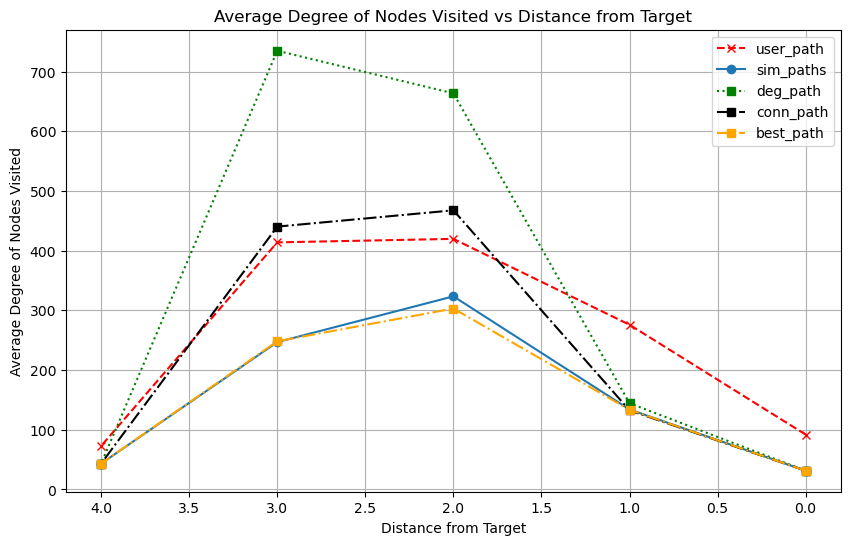

In [23]:
# Calculate average degrees for each path set
user_distances, user_avg_degrees = calculate_average_degrees(user_path_5)
sim_distances, sim_avg_degrees = calculate_average_degrees(sim_path_5)
deg_distances, deg_avg_degrees = calculate_average_degrees(deg_path_5)
conn_distances, conn_avg_degrees = calculate_average_degrees(conn_path_5)
best_distances, best_avg_degrees = calculate_average_degrees(best_path_5)

# Step 4: Plot the results with flipped x-axis
plt.figure(figsize=(10, 6))
plt.plot(user_distances, user_avg_degrees, marker='x', linestyle='--', label='user_path', color='red')
plt.plot(sim_distances, sim_avg_degrees, marker='o', label='sim_paths')
plt.plot(deg_distances, deg_avg_degrees, marker='s', linestyle=':', label='deg_path', color='green')
plt.plot(conn_distances, conn_avg_degrees, marker='s', linestyle='-.', label='conn_path', color='black')
plt.plot(best_distances, best_avg_degrees, marker='s', linestyle='-.', label='best_path', color='orange')

plt.xlabel('Distance from Target')
plt.ylabel('Average Degree of Nodes Visited')
plt.title('Average Degree of Nodes Visited vs Distance from Target')
plt.legend()
plt.gca().invert_xaxis()  # Flip the x-axis so distance 0 is on the right
plt.grid(True)
plt.savefig('avg_deg', bbox_inches='tight')
plt.show()

In [24]:
# Function to compute text similarity between two pages
def compute_similarity(page1, page2):
    # Get the indices of the pages in the TF-IDF matrix
    index1 = node_index[page1]
    index2 = node_index[page2]
    similarity = cosine_sim_matrix[index1][index2]
    return similarity

def compute_similarity_at_each_distance(paths):
    distance_dict = {}
    
    for path in paths:
        final_node = path[-1]
        reversed_path = list(reversed(path[:-1]))
        
        for distance, node in enumerate(reversed_path):
            similarity = compute_similarity(node, final_node)
            
            if distance not in distance_dict:
                distance_dict[distance] = []
            distance_dict[distance].append(similarity)
    
    avg_similarities = []
    distances = sorted(distance_dict.keys())
    for distance in distances:
        avg_similarity = np.mean(distance_dict[distance])
        avg_similarities.append(avg_similarity)
    
    return distances, avg_similarities

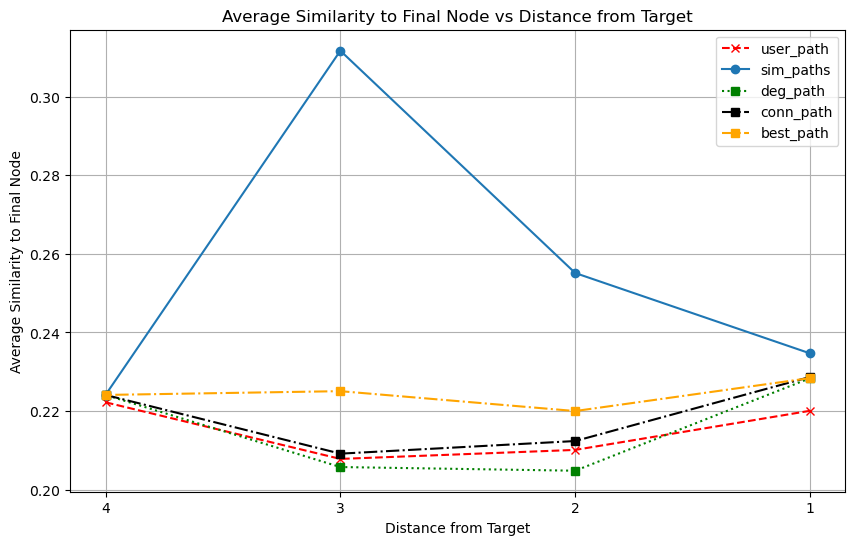

In [25]:
# Compute the average similarity at each distance for the paths
user_distances, user_avg_similarities = compute_similarity_at_each_distance(user_path_5)
sim_distances, sim_avg_similarities = compute_similarity_at_each_distance(sim_path_5)
deg_distances, deg_avg_similarities = compute_similarity_at_each_distance(deg_path_5)
conn_distances,conn_avg_similarities = compute_similarity_at_each_distance(conn_path_5)
best_distances, best_avg_similarities = compute_similarity_at_each_distance(best_path_5)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(user_distances, user_avg_similarities, marker='x', linestyle='--', label='user_path', color='red')
plt.plot(sim_distances, sim_avg_similarities, marker='o', label='sim_paths')
plt.plot(deg_distances, deg_avg_similarities, marker='s', linestyle=':', label='deg_path', color='green')
plt.plot(conn_distances, conn_avg_similarities, marker='s', linestyle='-.', label='conn_path', color='black')
plt.plot(best_distances, best_avg_similarities, marker='s', linestyle='-.', label='best_path', color='orange')

plt.xlabel('Distance from Target')
plt.ylabel('Average Similarity to Final Node')
plt.title('Average Similarity to Final Node vs Distance from Target')
plt.legend()
plt.gca().invert_xaxis()  # Flip the x-axis so distance 0 is on the right
plt.xticks(ticks=[3, 2, 1, 0], labels=[4, 3, 2, 1])
plt.grid(True)
plt.savefig('sim_paths', bbox_inches = 'tight')
plt.show()

In [55]:
#Implementation of West's algorithm
import networkx as nx

def V_deg(u, t, graph):
    # Evaluation function that returns the out-degree of node u
    return graph.out_degree(u)

def compute_similarity(page1, page2):
    # Get the indices of the pages in the TF-IDF matrix
    index1 = node_index[page1]
    index2 = node_index[page2]
    similarity = cosine_sim_matrix[index1][index2]
    return similarity

def V_sim(u, t, graph):
    return compute_similarity(u, t)

def V_conn(u, t, graph):
    return appearance_matrix[node_index[u]][node_index[t]]

def navigate(graph, s, t, V):
    stack = [s]
    visited = set()
    
    while stack:
        u = stack.pop()
        if u not in visited:
            visited.add(u)
            path.append(u)
        
            if u == t:
                return list(visited)
            
            # Get neighbors not visited and sort them by the out-degree
            neighbors = sorted((node for node in graph.successors(u) if node not in visited),
                               key=lambda node: V(node, t, graph), reverse=False)
            # neighbors = random.shuffle(neighbors)
            for u_prime in neighbors:
                stack.append(u_prime)
                if u_prime == t:
                    break  # Ensure target node t is revisited immediately in the next iteration
    
    return None

In [56]:
# path_sets = []
# path_len_sets = []

In [69]:
print(len(paths_cc))

41936


In [75]:
long_deg = []
long_deg_len = []
for path in paths_cc:
    p = navigate(G_cc, path[0], path[-1], V_deg)
    long_deg.append(p)
    long_deg_len.append(len(p))

In [76]:
long_sim = []
long_sim_len = []
for path in paths_cc:
    p = navigate(G_cc, path[0], path[-1], V_sim)
    long_sim.append(p)
    long_sim_len.append(len(p))

In [77]:
long_conn = []
long_conn_len = []
for path in paths_cc:
    p = navigate(G_cc, path[0], path[-1], V_conn)
    long_conn.append(p)
    long_conn_len.append(len(p))

In [83]:
best_mean = np.mean(best_path_lens)
print(np.mean(long_conn_len))
print(np.mean(long_sim_len))
print(np.mean(long_deg_len))
print(np.mean(user_path_lens))
print(np.mean(best_path_lens))

5.0785721098817245
245.16754101487982
168.19117226249523
5.719739603204884
3.8001001526135063


In [97]:
print(np.median(long_conn_len))
print(np.median(long_sim_len))
print(np.median(long_deg_len))
print(np.median(user_path_lens))
print(np.median(best_path_lens))

5.0
51.0
39.0
5.0
4.0


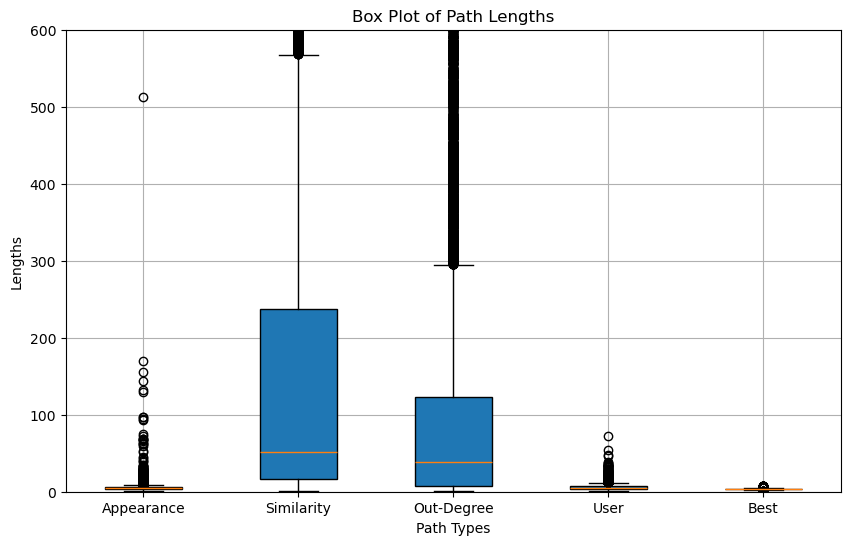

In [100]:
# Create a box plot
data = [long_conn_len, long_sim_len, long_deg_len, user_path_lens, best_path_lens]
labels = ['Appearance', 'Similarity', 'Out-Degree', 'User', 'Best']

plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels, patch_artist=True)
plt.xlabel('Path Types')
plt.ylabel('Lengths')
plt.title('Box Plot of Path Lengths')
plt.ylim(0, 600)  # Limit the height to 1000
plt.savefig('all_box')
plt.grid(True)
plt.show()


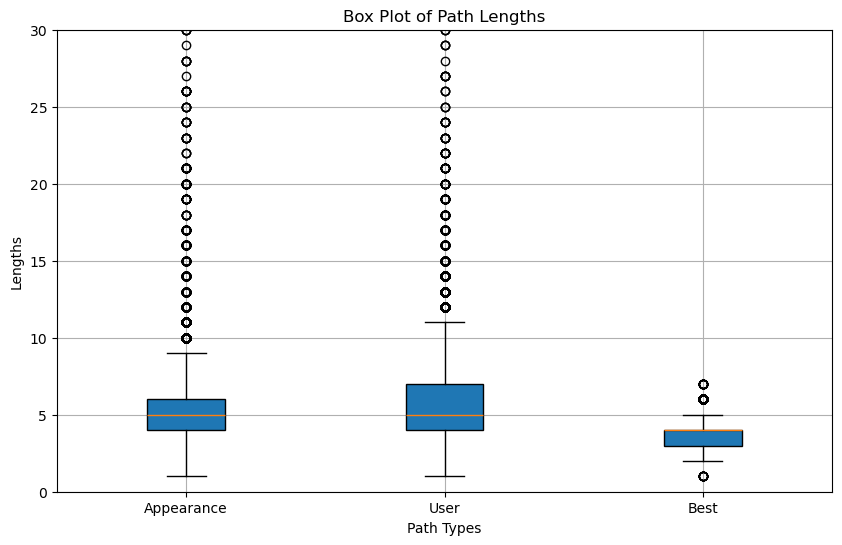

In [106]:
# Create a box plot
data = [long_conn_len, user_path_lens, best_path_lens]
labels = ['Appearance', 'User', 'Best']

plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels, patch_artist=True)
plt.xlabel('Path Types')
plt.ylabel('Lengths')
plt.title('Box Plot of Path Lengths')
plt.savefig('small_box')
plt.ylim(0, 30)  # Limit the height to 1000
plt.savefig
plt.grid(True)
plt.show()


In [107]:
with open('long_conn.pkl', 'wb') as file:
    pickle.dump(long_conn, file)
with open('long_sim.pkl', 'wb') as file:
    pickle.dump(long_sim, file)
with open('long_deg.pkl', 'wb') as file:
    pickle.dump(long_deg, file)

In [87]:
long_conn_len = np.array(long_conn_len)
long_sim_len = np.array(long_sim_len)
long_deg_len = np.array(long_deg_len)
user_path_lens = np.array(user_path_lens)
best_path_lens = np.array(best_path_lens)

5.719739603204884


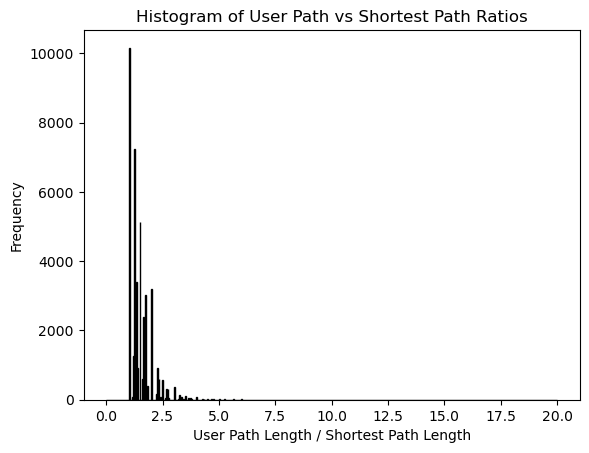

In [93]:
# Plot the histogram
plt.hist(user_path_lens/best_path_lens, bins=500, edgecolor='black', range=(0,20))
plt.xlabel('User Path Length / Shortest Path Length')
plt.ylabel('Frequency')
plt.title('Histogram of User Path vs Shortest Path Ratios')
plt.savefig('user_vs_best', bbox_inches='tight')
plt.show()

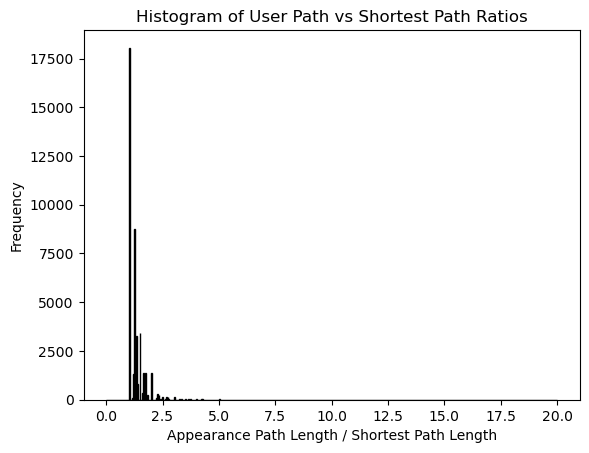

In [94]:
# Plot the histogram
plt.hist(long_conn_len/best_path_lens, bins=500, edgecolor='black', range=(0,20))
plt.xlabel('Appearance Path Length / Shortest Path Length')
plt.ylabel('Frequency')
plt.title('Histogram of User Path vs Shortest Path Ratios')
plt.savefig('appearance_vs_best', bbox_inches='tight')
plt.show()

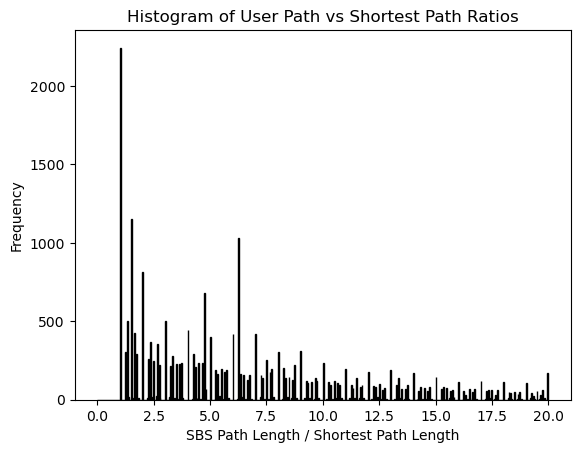

In [95]:
# Plot the histogram
plt.hist(long_sim_len/best_path_lens, bins=500, edgecolor='black', range=(0,20))
plt.xlabel('SBS Path Length / Shortest Path Length')
plt.ylabel('Frequency')
plt.title('Histogram of User Path vs Shortest Path Ratios')
plt.savefig('sbs_r_vs_best', bbox_inches='tight')
plt.show()

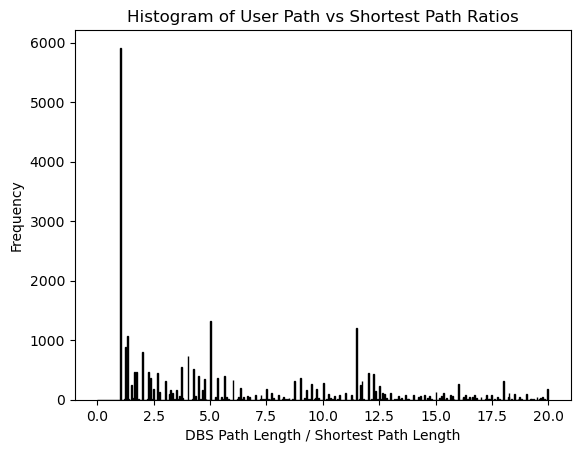

In [96]:
# Plot the histogram
plt.hist(long_deg_len/best_path_lens, bins=500, edgecolor='black', range=(0,20))
plt.xlabel('DBS Path Length / Shortest Path Length')
plt.ylabel('Frequency')
plt.title('Histogram of User Path vs Shortest Path Ratios')
plt.savefig('dbs_vs_best', bbox_inches='tight')
plt.show()

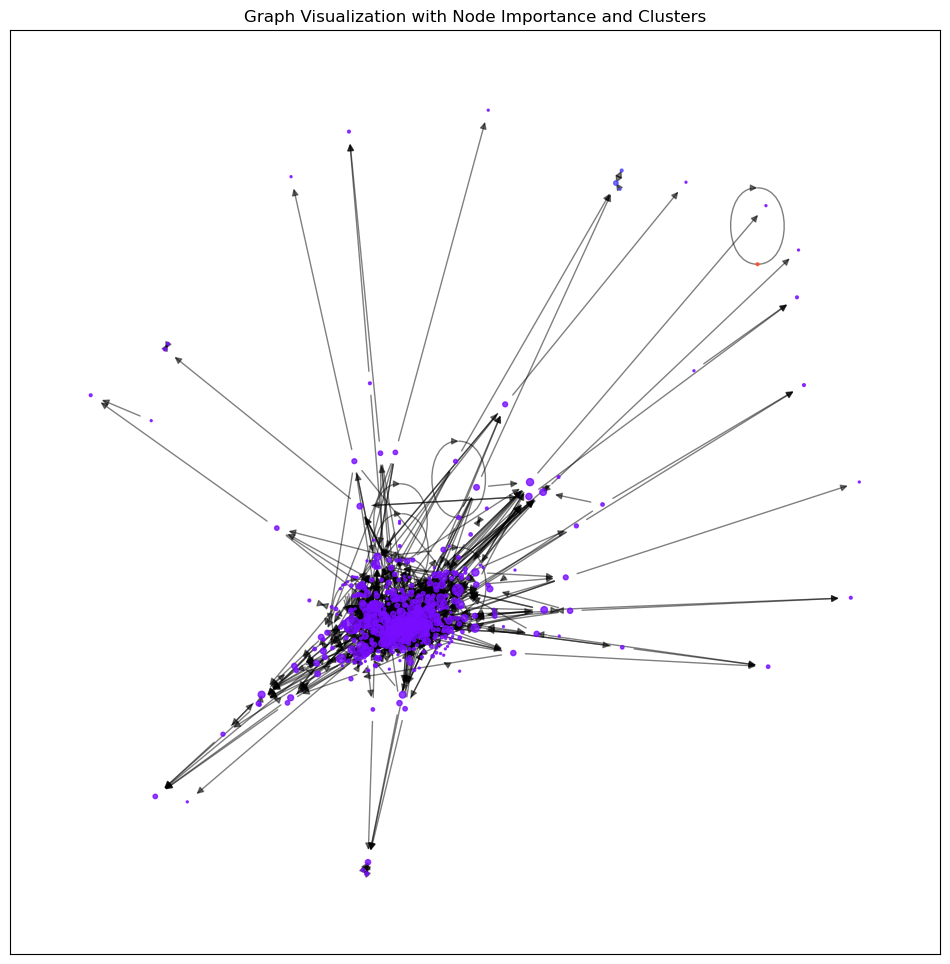

In [26]:

# Compute centrality measures
def compute_centrality_measures(G):
    centrality = nx.degree_centrality(G)
    # Other centrality measures can also be computed similarly
    return centrality

# Detect clusters using the Girvan-Newman algorithm
def detect_communities(G):
    comp = community.girvan_newman(G)
    limited = next(comp)  # Get the first level of the hierarchy
    return limited

# Draw the graph with node importance and clusters
def draw_graph_with_importance_and_clusters(G, node_sample_size=500, seed=42):
    # Sample a subset of nodes for visualization if the graph is too large
    if len(G.nodes) > node_sample_size:
        nodes = list(G.nodes)
        sampled_nodes = set(random.sample(nodes, node_sample_size))
        subgraph = G.subgraph(sampled_nodes)
    else:
        subgraph = G

    # Compute centrality measures
    centrality = compute_centrality_measures(subgraph)
    
    # Detect communities
    communities = detect_communities(subgraph)
    
    # Assign colors to communities
    community_map = {}
    for i, community in enumerate(communities):
        for node in community:
            community_map[node] = i
    
    # Compute the spring layout
    pos = nx.spring_layout(subgraph, seed=seed)

    # Draw the nodes and edges
    plt.figure(figsize=(12, 12))
    
    # Draw nodes with sizes proportional to their centrality
    nx.draw_networkx_nodes(subgraph, pos,
                           node_size=[v * 1000 for v in centrality.values()],
                           node_color=[community_map.get(node, 0) for node in subgraph.nodes()],
                           cmap=plt.cm.rainbow, alpha=0.8)
    
    # Draw edges
    nx.draw_networkx_edges(subgraph, pos, alpha=0.5)
    
    plt.title('Graph Visualization with Node Importance and Clusters')
    plt.savefig('importance', bbox_inches='tight')
    plt.show()

# Example usage
draw_graph_with_importance_and_clusters(G)


In [ ]:
t